<a href="https://colab.research.google.com/github/ccstudentcc/colab/blob/main/Special_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/KAN-Symbolic_Regression/

/content/drive/MyDrive/KAN-Symbolic_Regression


In [7]:
!pip install pykan

In [8]:
!python efficient_kan/__init__.py

Traceback (most recent call last):
  File "/content/drive/MyDrive/KAN-Symbolic_Regression/efficient_kan/__init__.py", line 1, in <module>
    from .kan import KANLinear, KAN
ImportError: attempted relative import with no known parent package


In [9]:
import torch
from kan import KAN as PyKAN
from kan.utils import create_dataset, add_symbolic
from matplotlib import pyplot as plt
from torch import nn, optim
from tqdm import tqdm

from efficient_kan.kan import KAN as EffKAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Special function (sine integral)

In this test we consider the sine integral special function:

$$Si(x) = \int_0^x \frac{\sin(t)}{t} dt$$

This function cannot be represented as a composition of common functions and is therefore a special function. Unlike other symbolic regression algorithms, PyKAN is able to approximate it anyway, although the accuracy depends on the depth of the architecture.

For reasons of interpretability, we train a rather small network, foregoing high accuracy.

## Dataset definition and plotting

In [108]:
steps = 1000
sine_integral = lambda x: torch.stack(
    [-torch.trapz(
        torch.sin(torch.linspace(0.000001, xi.item(), steps=steps)) /
        torch.linspace(0.000001, xi.item(), steps=steps), dx=xi.item() / steps
    ) for xi in x]
)

dataset = create_dataset(sine_integral, n_var=1, ranges=[-20, 20], train_num=5000, normalize_label=True,
                         normalize_input=True)

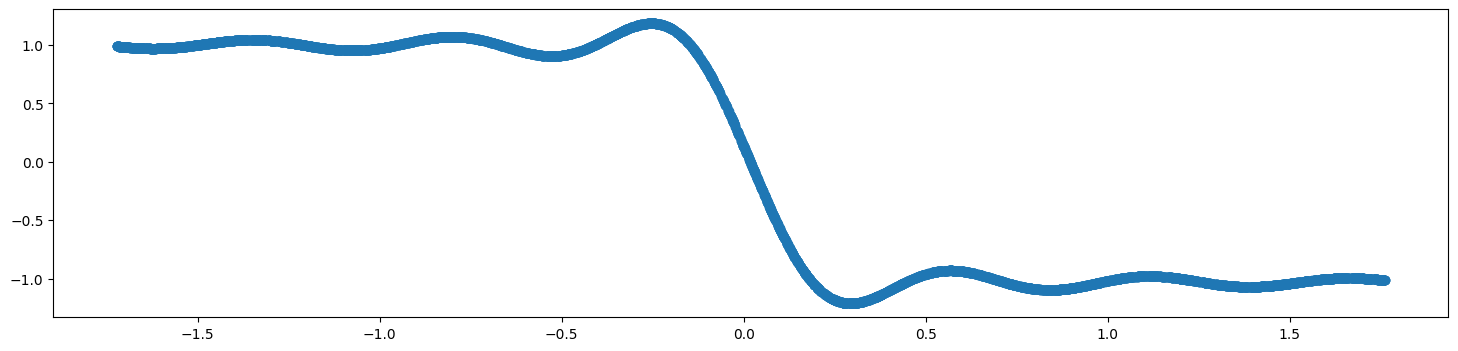

In [110]:
fig, ax = plt.subplots()
ax.scatter(dataset["train_input"].to('cpu'), dataset["train_label"].to('cpu'))
fig.set_size_inches(18, 4)
plt.show()

## PyKAN training

In [27]:
model = PyKAN(width=[1, 2, 1, 1], grid=5, k=3)
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001, lamb_entropy=4)
pass

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.90e-02 | test_loss: 3.84e-02 | reg: 1.58e+01 | : 100%|█| 50/50 [00:19<00:00,  2.53it


saving model version 0.1


### What did the PyKAN understand?
Providing a linespace to the model, we figure out how the KAN sees the learned function.

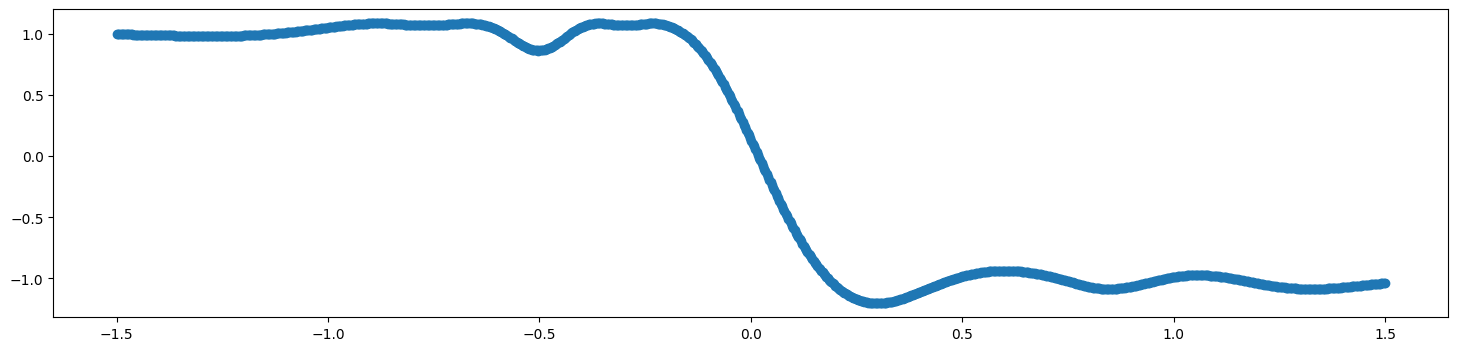

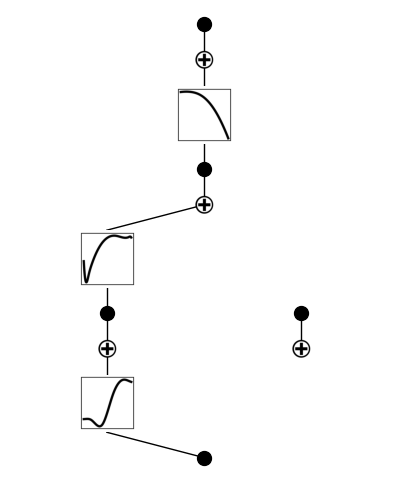

In [28]:
x_axis = torch.linspace(-1.5, 1.5, steps=steps)
y_axis = model(x_axis.view(-1, 1)).detach().numpy()
fig, ax = plt.subplots()
ax.scatter(x_axis, y_axis)
fig.set_size_inches(18, 4)
plt.show()
model.plot(scale=.5)

In [29]:
add_symbolic('sinx', lambda x:torch.sin(x).mul_(x))

In [30]:
model.suggest_symbolic(0,0,0)
model.suggest_symbolic(1,0,0)
model.suggest_symbolic(2,0,0)



  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0     sinx    0.987741 -6.348810           1                1   -0.469762
1        0    0.000000  0.000014           0                0    0.000003
2        x    0.815381 -2.437298           1                1    0.312540
3      cos    0.979912 -5.636790           2                2    0.472642
4      sin    0.979912 -5.636782           2                2    0.472644
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0     sinx    0.943728 -4.151186           1                1   -0.030237
1        0    0.000000  0.000014           0                0    0.000003
2        x    0.833204 -2.583753           1                1    0.283249
3      cos    0.921796 -3.676435           2                2    0.864713
4      sin    0.921796 -3.676434           2                2    0.864713
  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0     sinx    0.999634 -11.378687    

('sinx',
 (<function __main__.<lambda>(x)>, sinx, 1, <function __main__.<lambda>(x)>),
 np.float64(0.9996344447135925),
 np.int64(1))

r2 is 0.9877407550811768
saving model version 0.2
r2 is 0.9437281489372253
saving model version 0.3
r2 is 0.9996344447135925
saving model version 0.4


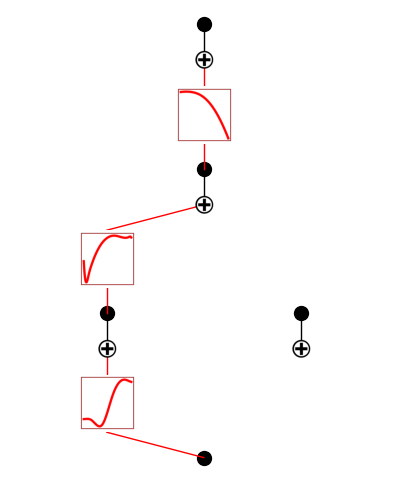

In [31]:
model.fix_symbolic(0, 0, 0, 'sinx')
model.fix_symbolic(1, 0, 0, 'sinx')
model.fix_symbolic(2, 0, 0, 'sinx')
model.plot()
pass

In [32]:
formula = model.symbolic_formula()[0]
formula

[-4.54622316360474*sinx(-0.0713985660715801*sinx(1.00947180569558*sinx(-1.64999985694885*x_1 - 3.15895986557007) + 3.35410163242912) - 5.26897373378762) - 20.7749729156494]

# EfficientKAN
We conclude this test proving that EfficientKAN can also reach great accuracy.

In [111]:
class Efficient_KAN(nn.Module):
    def __init__(self, grid_size=200):
        super(Efficient_KAN, self).__init__()
        self.layers = [1, 1]
        self.model = EffKAN(self.layers,
                            grid_size=grid_size,
                            # grid_eps=1,
                            # scale_base=0,
                            # sp_trainable=False,
                            # sb_trainable=False,
                            # enable_standalone_scale_spline=False
                            ).to(device)
        self.double()

    def forward(self, x):
        # x = x / dataset_size * 2 - 1
        # x = x.view(-1, self.layers[0])
        x = self.model(x)
        return x

In [112]:
def train(model, optimizer, inputs: torch.Tensor, labels, epochs=5, batch_size=100):
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    for epoch in range(epochs):
        model.train()
        with tqdm(range(inputs.size(0) // batch_size)) as pbar:
            for i in pbar:
                x = inputs[i * batch_size:(i + 1) * batch_size].to(device)
                y = labels[i * batch_size:(i + 1) * batch_size].to(device)
                optimizer.zero_grad()
                output = model(x)
                output = output.squeeze()
                loss = criterion(output, y.double())
                loss.backward()
                optimizer.step(closure=lambda: loss)
                pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
                scheduler.step()

In [113]:
model2 = Efficient_KAN(grid_size=20)
train(model2, optim.Adam(model2.parameters(), lr=0.025), dataset["train_input"], dataset["train_label"], epochs=20,
      batch_size=100)

100%|██████████| 50/50 [00:00<00:00, 346.63it/s, loss=0.992, lr=0.0092]


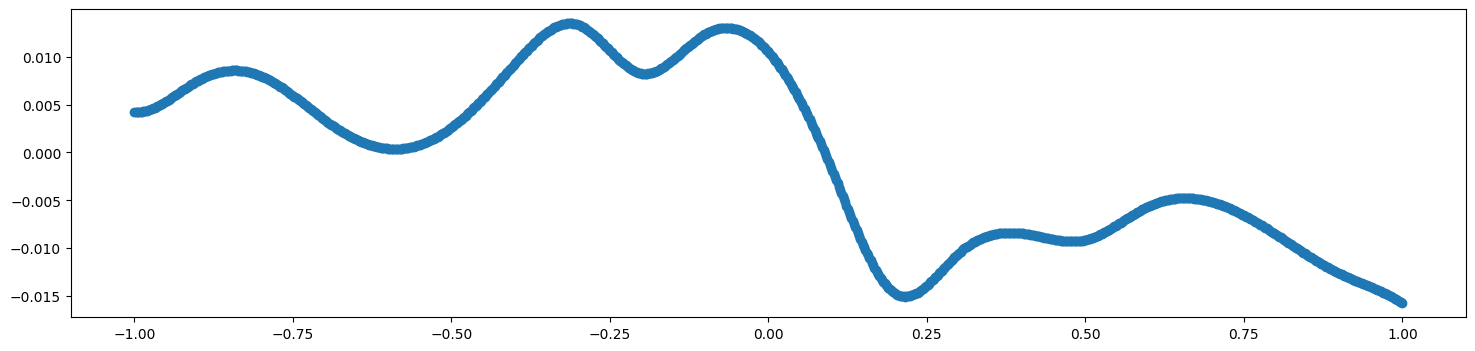

In [116]:
# 1. 生成x轴（需转为Double，与模型参数类型一致）
x_axis = torch.linspace(-1, 1, steps=steps).double()  # 关键：添加.double()
# 2. 模型预测：无需设备转移，直接在CPU上运行
y_axis = model2(x_axis.view(-1, 1)).detach().numpy()  # 删除.to('cuda')和.to('cpu')
# 3. 绘图（x_axis是张量，可直接用于scatter）
fig, ax = plt.subplots()
ax.scatter(x_axis, y_axis)
fig.set_size_inches(18, 4)
plt.show()


## A more complex KAN

In [20]:
model = PyKAN(width=[1, 5, 2, 1], grid=4, k=3)
model.fit(dataset, opt="LBFGS", steps=50, lr=1, lamb=0.00)
pass

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.75e-03 | test_loss: 2.84e-03 | reg: 1.79e+01 | : 100%|█| 50/50 [00:37<00:00,  1.35it

saving model version 0.1


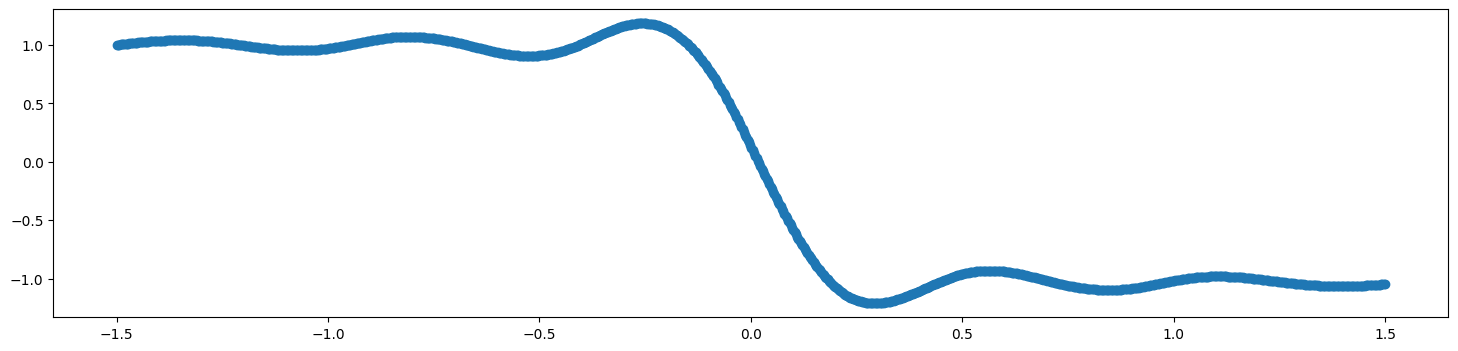

In [ ]:
x_axis = torch.linspace(-1.5, 1.5, steps=steps)
y_axis = model(x_axis.view(-1, 1)).detach().numpy()
fig, ax = plt.subplots()
ax.scatter(x_axis, y_axis)
fig.set_size_inches(18, 4)
plt.show()

model.plot(scale=1.5)